In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/My Drive/My_Colab_Works')
os.listdir()

['08_US_Airlines_Sentiment_Analysis_RNN_Yuliia_Kanarovska',
 'Kaggle_Digits_Recognizer']

In [4]:
train_data = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_Digits_Recognizer/data/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_Digits_Recognizer/data/test.csv')

In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
Y_train = train_data.pop('label').to_numpy()
X_train = train_data

In [8]:
def unstack_img(df):
    X = list()
    for _, row in df.iterrows():
        row = row.to_numpy()
        row_2d = np.reshape(row, (1, 28, 28))
        X.append(row_2d)
        
    return np.array(X)

In [9]:
X_np = unstack_img(X_train)

In [10]:
X_np.shape

(42000, 1, 28, 28)

In [11]:
def build_loaders(X_train, y_train, batch_size=20):
    
    tensor_x_train = torch.Tensor(X_train)
    tensor_y_train = torch.Tensor(y_train)
    
    train_dataset = TensorDataset(tensor_x_train,tensor_y_train)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

In [12]:
train_loader = build_loaders(X_np, Y_train, 64)

In [13]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.reshape(img, (28, 28)))

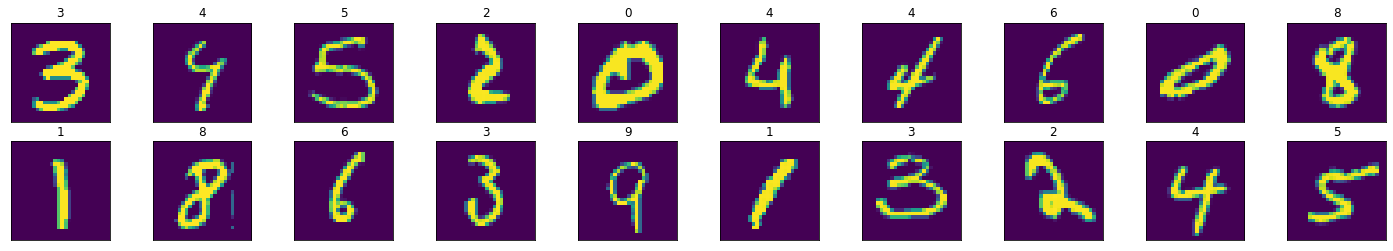

In [16]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[int(labels[idx])])

In [17]:
class CustomCNNModdel(nn.Module):
    def __init__(self):
        super(CustomCNNModdel, self).__init__()
        #convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) #"28x28"
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(16)
        self.bn_2 = nn.BatchNorm2d(32)
        self.bn_3 = nn.BatchNorm2d(64)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn_1(self.conv1(x)))) #14
        x = self.pool(F.relu(self.bn_2(self.conv2(x)))) #7
        x = F.relu(self.bn_3(self.conv3(x))) # 7 -> 7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        x = self.fc3(x)
        return x

In [18]:
model = CustomCNNModdel()
print(model)

CustomCNNModdel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

1696618


In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [21]:
def train_model(model, train_loader, criterion, optimizer, n_epochs=10):
    
    loss = np.Inf
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        correct = 0.0

        for data, target in train_loader:
            

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.long())
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).float().sum()
            
    train_loss = train_loss/len(train_loader.dataset)
    accur = correct/len(train_loader.dataset)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.6f}'.format(epoch, train_loss, accur))

In [22]:
train_model(model, train_loader, criterion, optimizer, 4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 4 	Training Loss: 0.032640 	Accuracy: 0.990452


In [23]:
X_np = unstack_img(test_data)

In [24]:
X_np.shape

(28000, 1, 28, 28)

In [25]:
model.eval()

output = model(torch.Tensor(X_np))
_, y_pred = torch.max(output.data, 1)

In [26]:
y_pred.numpy().shape

(28000,)

In [27]:
submission_pd = pd.read_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_Digits_Recognizer/data/sample_submission.csv')

In [28]:
submission_pd.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [29]:
submission_pd['Label'] = np.resize(y_pred,len(submission_pd))
submission_pd.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [30]:
submission_pd.to_csv('/content/gdrive/My Drive/My_Colab_Works/Kaggle_Digits_Recognizer/data/submission_v3.csv', index=False, encoding='utf-8-sig')